Avec les mêmes données des post Python et R nous allons entrainer deux modèles des réseau de neurones
avec Keras et TensorFlow

# importation du dataset et conversion

In [2]:
import numpy as np
import pandas as pd

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str',
                    'Body': 'str', 'Title_raw': 'str', 'Text': 'str',
                    'Tags': 'str','Text_raw':'str'}

nrows = 20000

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=dtypes_questions.keys(),
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=nrows
                          )


text_train, tag_train = df_questions.Text_raw, df_questions.Tags

Nous obtenons un boost de performance en utilisant le `texte brut` sans prétraitement passant d'un
f1 score de 82.6 %  à un f1 Score de 83.4 %, nous allons garder par la suite le texte sans prétraitement

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Nous créons un tokenizer, configuré pour ne prendre
# en compte que les 10000 mots les plus courants pour
# le texte et 100 pour les tags

tokenizer_X = Tokenizer(num_words=10000)
tokenizer_Y = Tokenizer(num_words=33)  # 33 tags limite pour un modèle à deux layers sans embedding

tokenizer_X.fit_on_texts(text_train)
tokenizer_Y.fit_on_texts(tag_train)

X_train = tokenizer_X.texts_to_matrix(text_train, mode='binary')
Y_train = tokenizer_Y.texts_to_matrix(tag_train, mode='binary')

X_train_padded = pad_sequences(X_train, padding="post")
Y_train_padded = pad_sequences(Y_train, padding="post")

label_len=len(Y_train_padded[0])

# Les posts ont été randomisés dans le prétraitement, nous utilisons les premiers 1000 post
# comme Validation et les suivants 1000 comme notre test set le restant de notre dataset
# sera utilisé pour entrainement du modèle

X_val = X_train_padded[:1000]
X_test = X_train_padded[1000:2000]
partial_X_train = X_train_padded[2000:]

Y_val = Y_train_padded[:1000]
Y_test = Y_train_padded[1000:2000]
partial_Y_train = Y_train_padded[2000:]

# Nous créons deux dictionnaires avec tous les mots trouvés dans le datasets et pas seulement
# ceux utilisés pour vectoriser les datas, nous avons donc  61769 mots pour les posts et
# 2966 mots pour les tags. Nous créons aussi un dictionnaire inversée que va nous servir pour
# traduire les prédictions du modèle

word_index_X = tokenizer_X.word_index
word_index_Y = tokenizer_Y.word_index

reverse_word_index_Y = dict (
    [(value,key) for (key,value) in word_index_Y.items()]
)
print('Found %s unique tokens in the posts.' % len(word_index_X))
print('Found %s unique tokens in the tags.' % len(word_index_Y))

Found 61769 unique tokens in the posts.
Found 2966 unique tokens in the tags.


In [4]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(label_len, activation='sigmoid'))

Le modèle choisi est composé de deux couches denses avec 100 unité chacun qui semblé
être bien adapté pour liste de 32 tags, lors du passage à 100 tags
le réseux n'est plus capable d'apprendre plus de deux tags, nous avons
donc augmenté le nombre d'unités des deux premières couches allant jusqu'à 5000 unités
et nous avons aussi essayé d'aumenter le nombre de couches sans succès

In [5]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [6]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

In [7]:

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(X_val, Y_val))
model.summary()

Epoch 1/30
24/24 [==============================] - 1s 16ms/step - loss: 0.3328 - acc: 0.4733 - f1_m: 0.3852 - precision_m: 0.4786 - recall_m: 0.3572 - val_loss: 0.1424 - val_acc: 0.7460 - val_f1_m: 0.5686 - val_precision_m: 0.7463 - val_recall_m: 0.4593
Epoch 2/30
24/24 [==============================] - 0s 8ms/step - loss: 0.1298 - acc: 0.7233 - f1_m: 0.5477 - precision_m: 0.7217 - recall_m: 0.4414 - val_loss: 0.1192 - val_acc: 0.7460 - val_f1_m: 0.5692 - val_precision_m: 0.7466 - val_recall_m: 0.4599

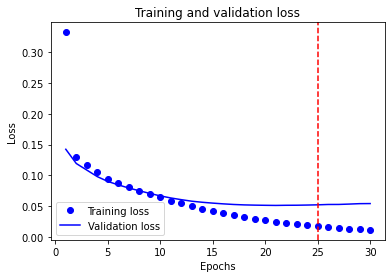

In [8]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=25,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

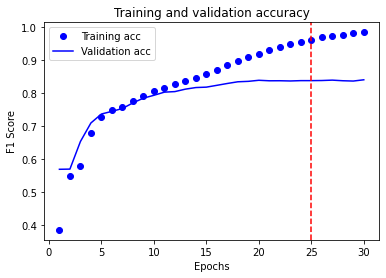

In [9]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=25,color='red',linestyle='--')

plt.show()

In [10]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.055799514055252075
Accuracy :  0.9549999833106995
f1 Score :  0.8352599740028381
precision :  0.9263651967048645
recall :  0.7628250122070312


In [11]:
Y_predict = model.predict(X_train_padded)

In [12]:
Y_predict_ones = (Y_predict>0.5).astype(int)
np.sum(Y_predict_ones,axis=0)

array([    0, 10078,  3936,   821,   623,   522,   512,   412,   375,
         334,   352,   273,   277,   248,   268,   230,   179,   232,
         187,   148,   185,   198,   179,   147,    57,   142,   124,
         140,    88,   102,   114,   119,   128])

In [13]:
# On re entraine le modèle du début pour 25 epoch
model = models.Sequential()
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=25,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )
model.summary()

Epoch 1/25
24/24 [==============================] - 1s 15ms/step - loss: 0.3259 - acc: 0.4780 - f1_m: 0.3804 - precision_m: 0.5115 - recall_m: 0.3386 - val_loss: 0.1424 - val_acc: 0.7460 - val_f1_m: 0.5686 - val_precision_m: 0.7463 - val_recall_m: 0.4593
Epoch 2/25
24/24 [==============================] - 0s 8ms/step - loss: 0.1296 - acc: 0.7233 - f1_m: 0.5512 - precision_m: 0.7248 - recall_m: 0.4448 - val_loss: 0.1185 - val_acc: 0.7460 - val_f1_m: 0.5741 - val_precision_m: 0.7488 - val_recall_m: 0.4654

In [14]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.051705941557884216
Accuracy :  0.968999981880188
f1 Score :  0.8360462188720703
precision :  0.9442397356033325
recall :  0.7517367005348206


In [15]:
Y_predict = model.predict(X_train_padded)

In [16]:
def vector_to_list_of_tags(vect_tag,reverse_word_ind):
    tag_list=[]
    for i in range(len(vect_tag)):
        if vect_tag[i]>0 :
            tag_list.append(reverse_word_ind.get(i,'?'))
    return tag_list

In [17]:
id_sample = 6

print('reverse word index Y : ',reverse_word_index_Y)
print('Tags before vectoring : ',tag_train[id_sample])
print('Tags vectorize matrix : ',Y_train_padded[id_sample])

sample_tag = vector_to_list_of_tags(Y_train_padded[id_sample],reverse_word_index_Y)
print('Tags vectorized : ',sample_tag)

Y_predict_ones = (Y_predict>0.5).astype(int)
sample_tag_pred = vector_to_list_of_tags(Y_predict_ones[id_sample],reverse_word_index_Y)
print('Tags predicted matrix: ',np.around(Y_predict[id_sample], decimals=1))
print('Tags predicted : ',sample_tag_pred)

reverse word index Y :  {1: 'python', 2: 'r', 3: 'django', 4: 'ggplot2', 5: 'list', 6: 'numpy', 7: 'string', 8: 'dataframe', 9: 'x', 10: 'matplotlib', 11: '3', 12: '2', 13: 'data', 14: 'dictionary', 15: 'regex', 16: 'file', 17: 'pandas', 18: 'plot', 19: '7', 20: 'table', 21: 'dplyr', 22: 'datetime', 23: 'testing', 24: 'faq', 25: 'flask', 26: 'class', 27: 'sqlalchemy', 28: 'function', 29: 'c', 30: 'import', 31: 'performance', 32: 'models', 33: 'windows', 34: 'scipy', 35: 'exception', 36: 'arrays', 37: 'unicode', 38: 'unit', 39: 'csv', 40: 'markdown', 41: 'date', 42: 'sorting', 43: 'matrix', 44: 'variables', 45: 'shiny', 46: 'io', 47: 'linux', 48: 'json', 49: 'time', 50: 'multithreading', 51: 'module', 52: 'knitr', 53: 'image', 54: 'tkinter', 55: 'mysql', 56: 'memory', 57: 'formatting', 58: 'pip', 59: 'statistics', 60: 'oop', 61: 'rstudio', 62: 'package', 63: 'processing', 64: 'syntax', 65: 'algorithm', 66: 'virtualenv', 67: 'logging', 68: 'google', 69: 'line', 70: 'parsing', 71: 'random

In [18]:
np.sum(Y_predict_ones,axis=0)

array([    0, 10069,  3937,   818,   628,   486,   513,   357,   335,
         318,   355,   229,   189,   203,   251,   223,    75,   227,
         111,    89,   172,   185,   161,    90,     3,   141,    90,
         136,     4,    93,    78,    76,    86])

# Embedding

In [19]:
from keras.layers import Embedding, Flatten

tokenizer_X = Tokenizer(num_words=10000)
tokenizer_Y = Tokenizer(num_words=100)  # 100 tags posible avec embedding avec des résultats corrects

tokenizer_X.fit_on_texts(text_train)
tokenizer_Y.fit_on_texts(tag_train)

X_train = tokenizer_X.texts_to_sequences(text_train)
Y_train = tokenizer_Y.texts_to_matrix(tag_train,mode='binary')

X_train_padded = pad_sequences(X_train, padding="post",maxlen=1000)
Y_train_padded = pad_sequences(Y_train, padding="post")

#X_train_padded = X_train_padded/len(word_index_X) #normalisation

text_len = len(X_train_padded[0])
label_len=len(Y_train_padded[0])

X_val = X_train_padded[:1000]
X_test = X_train_padded[1000:2000]
partial_X_train = X_train_padded[2000:]

Y_val = Y_train_padded[:1000]
Y_test = Y_train_padded[1000:2000]
partial_Y_train = Y_train_padded[2000:]

In [20]:

model = models.Sequential()
model.add(Embedding(10000, 100, input_length=text_len))
# our activations have shape `(samples, text_len, 20)`.
# We flatten the 3D tensor of embeddings
# into a 2D tensor of shape `(samples, text_len * 100)`
model.add(Flatten())
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=15,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

model.summary()

Epoch 1/15
24/24 [==============================] - 1s 37ms/step - loss: 0.1258 - acc: 0.6924 - f1_m: 0.4529 - precision_m: 0.6824 - recall_m: 0.3675 - val_loss: 0.0771 - val_acc: 0.7460 - val_f1_m: 0.4849 - val_precision_m: 0.7463 - val_recall_m: 0.3591

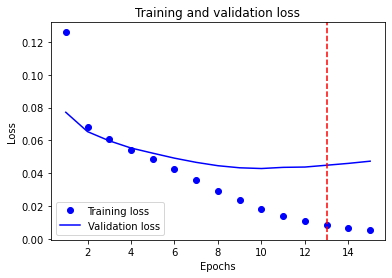

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=13,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

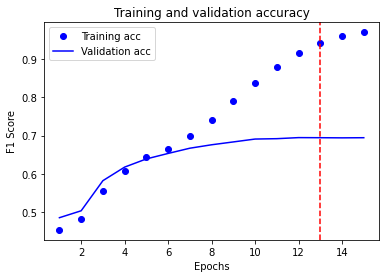

In [22]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=13,color='red',linestyle='--')

plt.show()

Nous observons un fort overfiting du modèle, nous allons ajouter
des couches dropout pour régulariser le modèle

In [23]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.04423646628856659
Accuracy :  0.9679999947547913
f1 Score :  0.7127317786216736
precision :  0.9652590155601501
recall :  0.5670835375785828


In [24]:

model = models.Sequential()
model.add(Embedding(10000, 30, input_length=text_len))
model.add(layers.Dropout(0.5))
model.add(Flatten())
# ajout de la régularisation par Dropout des 50% des unités
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=25,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

model.summary()

Epoch 1/25
24/24 [==============================] - 1s 22ms/step - loss: 0.1386 - acc: 0.6925 - f1_m: 0.4487 - precision_m: 0.6751 - recall_m: 0.3544 - val_loss: 0.0864 - val_acc: 0.7460 - val_f1_m: 0.4849 - val_precision_m: 0.7463 - val_recall_m: 0.3591
Epoch 2/25
24/24 [==============================]

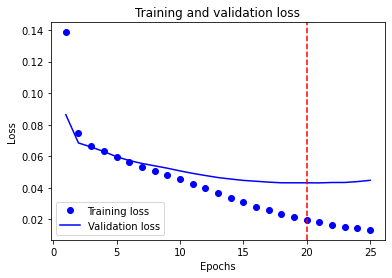

In [25]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=20,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

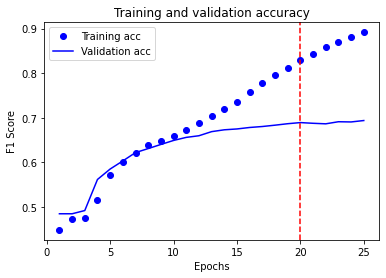

In [26]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=20,color='red',linestyle='--')

plt.show()

Nous n'observons plus un fort overfiting du modèle, après l'ajout
des couches dropout pour régulariser le modèle

In [27]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.0414847731590271
Accuracy :  0.9739999771118164
f1 Score :  0.7092535495758057
precision :  0.9632898569107056
recall :  0.5629729628562927


In [28]:
# On re entraine le modèle du début pour 20 epoch
model = models.Sequential()
model.add(Embedding(10000, 30, input_length=text_len))
# diminution de la dimension des embedings
model.add(layers.Dropout(0.5))
model.add(Flatten())
# ajout de la régularisation par Dropout des 50% des unités
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )
model.summary()

Epoch 1/20
24/24 [==============================] - 1s 23ms/step - loss: 0.1364 - acc: 0.6932 - f1_m: 0.4529 - precision_m: 0.6883 - recall_m: 0.3637 - val_loss: 0.0865 - val_acc: 0.7460 - val_f1_m: 0.4849 - val_precision_m: 0.7463 - val_recall_m: 0.3591
Epoch 2/20
24/24 [==============================] - 0s 

In [29]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.04006333649158478
Accuracy :  0.9760000109672546
f1 Score :  0.7045835256576538
precision :  0.9697743058204651
recall :  0.555048406124115


In [30]:
embedd_predict = model.predict(partial_X_train)
embedd_predict_ones = (embedd_predict>0.5).astype(int)

In [31]:
np.sum(embedd_predict_ones,axis=0)

array([   0, 8630, 3347,  653,  504,  292,  368,  181,  210,   90,  251,
         75,   48,  152,  124,   88,   63,  157,   84,   24,  151,  137,
         93,   69,   41,   61,   52,   77,   20,   30,   62,   49,   84,
         44,   53,   29,   56,   43,   57,   57,   72,   51,   25,   44,
         12,   50,   27,   20,   39,   21,   18,   29,   63,   47,   20,
         28,   35,    8,   42,   20,   19,   42,   38,   33,    7,   30,
         35,   33,   21,   14,   16,   15,   12,   28,   22,   28,   12,
         29,   11,   13,   18,   36,   17,   11,   18,    6,   10,   34,
         15,   17,    7,    6,   23,    3,   10,   17,   16,   11,   16,
         15])

In [32]:
np.sum(partial_Y_train,axis=0)

array([   0, 8617, 3372,  731,  547,  466,  449,  390,  338,  318,  298,
        273,  285,  264,  243,  223,  201,  209,  202,  193,  177,  180,
        168,  134,  148,  130,  134,  130,  130,  122,  133,  137,  124,
        118,  120,  111,  118,  113,  106,  105,   99,  102,  106,  103,
         97,   90,   93,   93,   94,   90,   78,   91,   87,   79,   83,
         80,   81,   83,   81,   75,   77,   80,   83,   82,   67,   75,
         77,   75,   72,   69,   74,   76,   67,   63,   70,   56,   64,
         69,   65,   65,   57,   62,   58,   58,   59,   55,   51,   56,
         56,   62,   58,   58,   52,   48,   54,   57,   57,   51,   56,
         45])

# Utilisation d'un embedding pré entrainé Glove

In [33]:
import os
# fichier téléchargé de https://nlp.stanford.edu/projects/glove/
glove_dir = 'embedding/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [34]:
max_words = 10000
embedding_dim = 50 # dimension du embedding importé glove.6B.50d.txt

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index_X.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [35]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(10000, embedding_dim, input_length=text_len))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(label_len, activation='sigmoid'))
model.summary()

# charger l'embedding entrainé
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])


history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

model.save_weights('pre_trained_glove_model.h5')


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               6400128   
_________________________________________________________________
dense_10 (Dense)             (None, 100)               12900     
Total params: 6,913,028
Trainable params: 6,913,028
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
24/24 [==============================] - 1s 26ms/step - loss: 0.2011 - acc: 0.6537 - f1_m: 0.3788 - precision_m: 0.5358 - recall_m: 0.3923 - val_loss: 0.0891 - val_acc: 0.7910 - val_f1_m: 0.5079 - val_precision_m: 0.7867 - val_reca

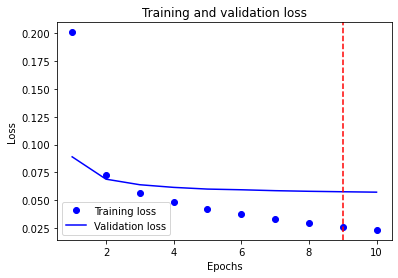

In [36]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=9,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

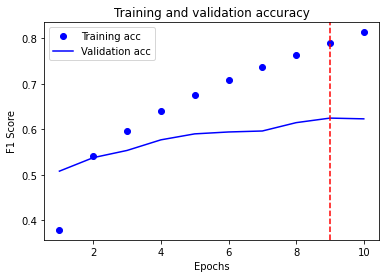

In [37]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=9,color='red',linestyle='--')

plt.show()

In [38]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.05715838819742203
Accuracy :  0.9350000023841858
f1 Score :  0.636742353439331
precision :  0.9285431504249573
recall :  0.48565441370010376


# LSTM model


In [39]:
from keras.layers import Embedding, Flatten

tokenizer_X = Tokenizer(num_words=10000)
tokenizer_Y = Tokenizer(num_words=100)  # 100 tags posible avec embedding avec des résultats corrects

tokenizer_X.fit_on_texts(text_train)
tokenizer_Y.fit_on_texts(tag_train)

X_train = tokenizer_X.texts_to_sequences(text_train)
Y_train = tokenizer_Y.texts_to_matrix(tag_train,mode='binary')

X_train_padded = pad_sequences(X_train, padding="post",maxlen=1000)
Y_train_padded = pad_sequences(Y_train, padding="post")

#X_train_padded = X_train_padded/len(word_index_X) #normalisation

text_len = len(X_train_padded[0])
label_len=len(Y_train_padded[0])

X_val = X_train_padded[:1000]
X_test = X_train_padded[1000:2000]
partial_X_train = X_train_padded[2000:]

Y_val = Y_train_padded[:1000]
Y_test = Y_train_padded[1000:2000]
partial_Y_train = Y_train_padded[2000:]

In [40]:
from keras.layers import LSTM

model = models.Sequential()
model.add(Embedding(10000, 30, input_length=text_len))
model.add(layers.LSTM(32))

model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

model.summary()

Epoch 1/10
24/24 [==============================] - 4s 91ms/step - loss: 0.6536 - acc: 4.1971e-04 - f1_m: 0.1005 - precision_m: 0.0559 - recall_m: 0.5479 - val_loss: 0.5282 - val_acc: 0.0000e+00 - val_f1_m: 0.1182 - val_precision_m: 0.0693 - val_recall_m: 0.4001

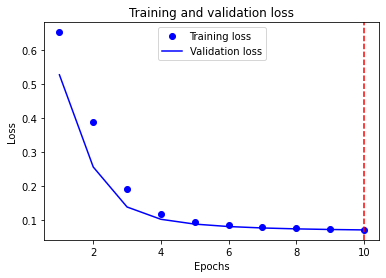

In [47]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=10,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

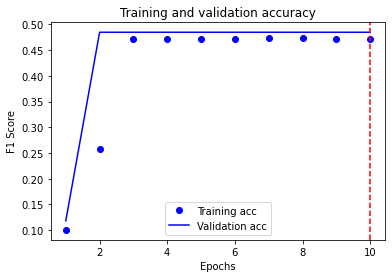

In [48]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=10,color='red',linestyle='--')

plt.show()

Nous n'observons plus un fort overfiting du modèle, après l'ajout
des couches dropout pour régulariser le modèle

In [43]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.07106947153806686
Accuracy :  0.7059999704360962
f1 Score :  0.4618774652481079
precision :  0.7041015625
recall :  0.34462496638298035


In [44]:
embedd_predict = model.predict(partial_X_train)
embedd_predict_ones = (embedd_predict>0.5).astype(int)

In [45]:
np.sum(embedd_predict_ones,axis=0)

array([    0, 11913,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [46]:
np.sum(partial_Y_train,axis=0)

array([   0, 8617, 3372,  731,  547,  466,  449,  390,  338,  318,  298,
        273,  285,  264,  243,  223,  201,  209,  202,  193,  177,  180,
        168,  134,  148,  130,  134,  130,  130,  122,  133,  137,  124,
        118,  120,  111,  118,  113,  106,  105,   99,  102,  106,  103,
         97,   90,   93,   93,   94,   90,   78,   91,   87,   79,   83,
         80,   81,   83,   81,   75,   77,   80,   83,   82,   67,   75,
         77,   75,   72,   69,   74,   76,   67,   63,   70,   56,   64,
         69,   65,   65,   57,   62,   58,   58,   59,   55,   51,   56,
         56,   62,   58,   58,   52,   48,   54,   57,   57,   51,   56,
         45])